# Yongjie's CA2-Stock Price Forecasting

Name: Li Yongjie

ID: 2342377

Class: DAAA/FT/1B/01

## Objective
Train time series models and forecast the stock price
of Apple, Amazon and DBS for the next 60 days

<hr>

## Importing Necassary Libraries
<hr>


In [17]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from tqdm import tqdm

# Metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Models
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX

# EDA + Model Selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings("ignore")


sns.set_theme(palette='bright')
# Set the style for plots
plt.style.use('seaborn-v0_8-darkgrid')


<hr>

## Loading Dataset
<hr>

In [18]:
# Load the dataset
df = pd.read_csv("./CA2-Stock-Price-Data.csv")

# Set Date as index
df["Date"] = pd.to_datetime(df["Date"])

df.set_index("Date", inplace=True)

df

,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
...,...,...,...
2023-09-22,174.789993,129.119995,33.250000
2023-09-25,176.080002,131.270004,33.450001
2023-09-26,171.960007,125.980003,33.509998


<hr>

## Exploratory Data Analysis
<hr>

Now we will conduct and exploratory data analysis of the dataset to gain a better understanding of the dataset. We will be trying to find

In [19]:
df_eda = df.copy()

In [4]:
df_eda.describe()

,Apple,Amazon,DBS
count,1257.000000,1257.000000,1257.000000
mean,116.168385,124.791237,28.185863
std,46.945568,32.495925,4.738732
min,35.547501,67.197998,16.879999
25%,66.592499,93.489998,24.879999
50%,129.610001,120.970001,28.650000
75%,152.589996,158.100494,32.480000
max,196.449997,186.570496,37.250000


In [5]:
df_eda.shape

(1257, 3)

In [6]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-10-01 to 2023-09-28
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Apple   1257 non-null   float64
 1   Amazon  1257 non-null   float64
 2   DBS     1257 non-null   float64
dtypes: float64(3)
memory usage: 39.3 KB


In [7]:
df_eda.isnull().sum()

Apple     0
Amazon    0
DBS       0
dtype: int64

In [21]:
df.index

DatetimeIndex(['2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04',
               '2018-10-05', '2018-10-08', '2018-10-09', '2018-10-10',
               '2018-10-11', '2018-10-12',
               ...
               '2023-09-15', '2023-09-18', '2023-09-19', '2023-09-20',
               '2023-09-21', '2023-09-22', '2023-09-25', '2023-09-26',
               '2023-09-27', '2023-09-28'],
              dtype='datetime64[ns]', name='Date', length=1257, freq=None)

In [20]:
pd.date_range(start = '2018-10-01', end = '2023-09-28', freq='D').difference(df.index)

DatetimeIndex(['2018-10-06', '2018-10-07', '2018-10-13', '2018-10-14',
               '2018-10-20', '2018-10-21', '2018-10-27', '2018-10-28',
               '2018-11-03', '2018-11-04',
               ...
               '2023-08-27', '2023-09-02', '2023-09-03', '2023-09-04',
               '2023-09-09', '2023-09-10', '2023-09-16', '2023-09-17',
               '2023-09-23', '2023-09-24'],
              dtype='datetime64[ns]', length=567, freq=None)

<hr>

## Visualising the dataset
<hr>

In [22]:
colors = ['#fe4a49', '#2ab7ca', '#fed766']

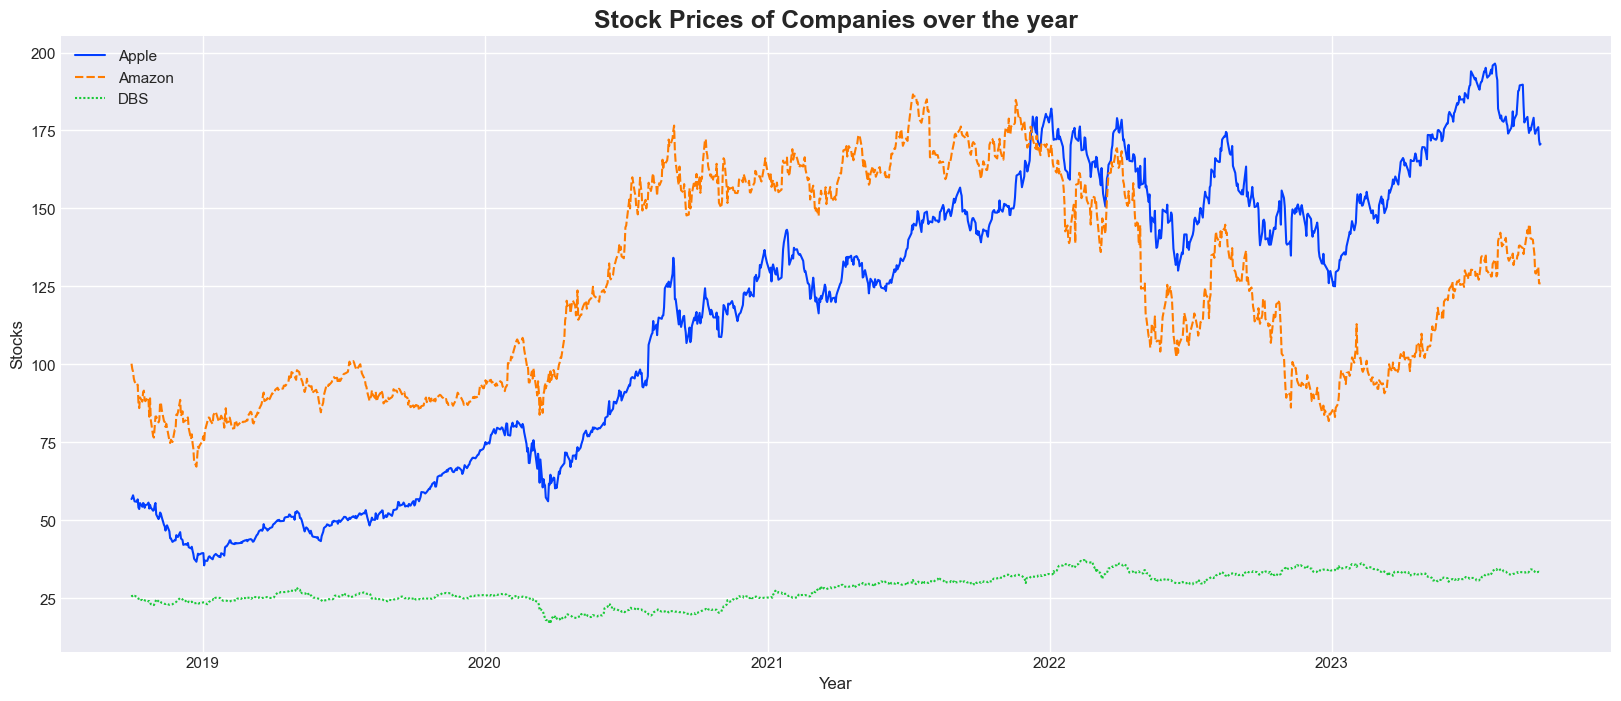

In [23]:
plt.figure(figsize=(20,8))

sns.lineplot(df_eda)

plt.xlabel('Year')
plt.ylabel('Stocks')
plt.title(f'Stock Prices of Companies over the year', fontweight='bold', fontsize=18)

plt.show()

<u>Observations</u>

We notice a consistent upward trend across all three columns throughout the years. This suggests that none of the columns exhibit stationarity, meaning their statistical properties, such as mean and variance, change over time. To ensure our model's accuracy, we'll need to address this non-stationarity during the training process. 

We can also see the moving average of each column


<hr>

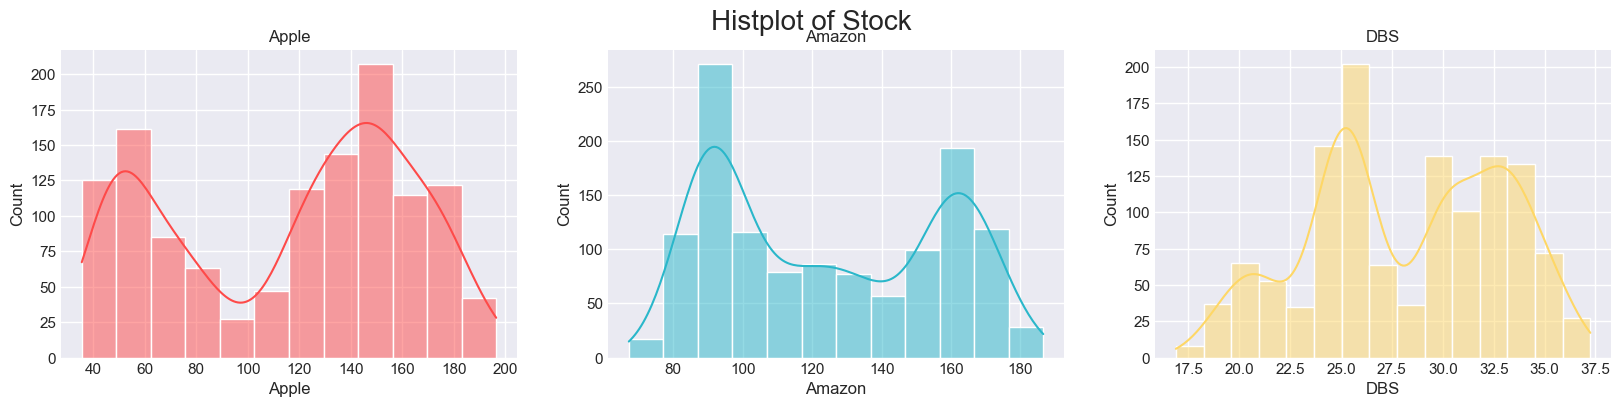

In [13]:
# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Enumerate over columns and plot histograms
for i, (col, color) in enumerate(zip(df_eda.columns, colors)):
    sns.histplot(data=df_eda, x=col, ax=ax[i], kde=True, color=color)
    ax[i].set_title(col)  # Set subplot title

# Set figure title
plt.suptitle('Histplot of Stock', fontsize=20)

# Show plot
plt.show()


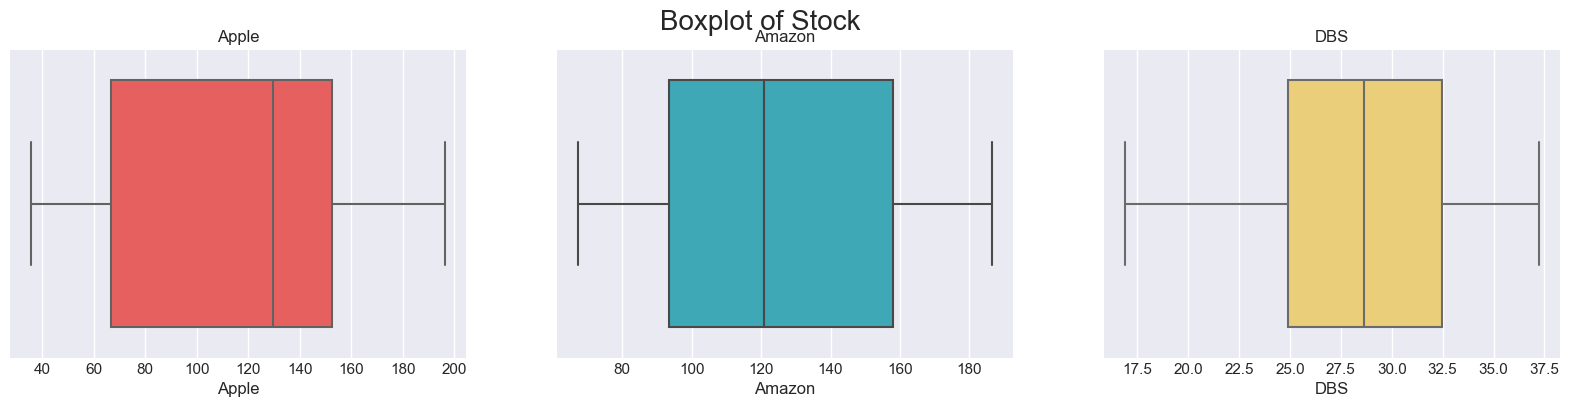

In [15]:
# Boxplots
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
for i, (col, color) in enumerate(zip(df_eda.columns, colors)):
    sns.boxplot(data=df_eda, x=col, ax=ax[i], color=color)
    ax[i].set_title(col)  # Set subplot title

    
plt.suptitle('Boxplot of Stock', fontsize=20)
plt.show()

The box plot shows we have no outliers in our dataset

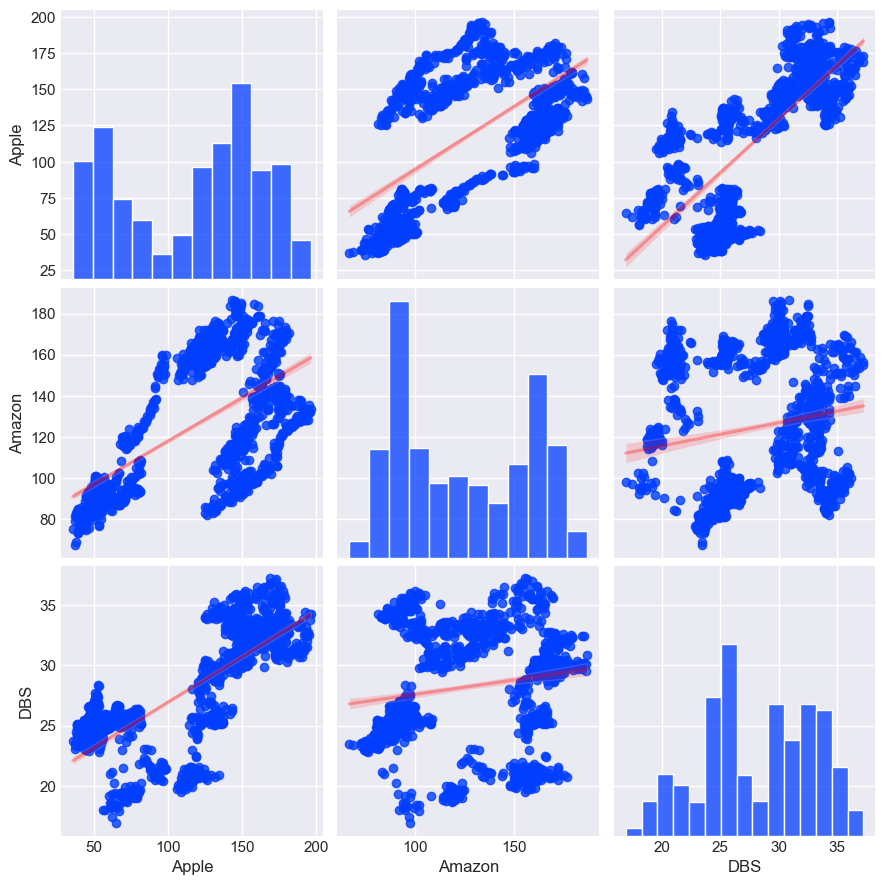

In [16]:
# Pairplot
sns.pairplot(df_eda, kind='reg', plot_kws={'line_kws':{'color':'red','alpha':0.3}},height=3)
plt.show()

<hr>

### Time Series Analysis
<hr>

#### Seasonal Decomposition
We will be doing Seasonal Decomposition to find the seasonal trend of each column. The decomposition procedure analyzes the seasonal indices and variation within each season of the time series. 

Seasonal Decomposition
Column: Apple
Seasonal 7


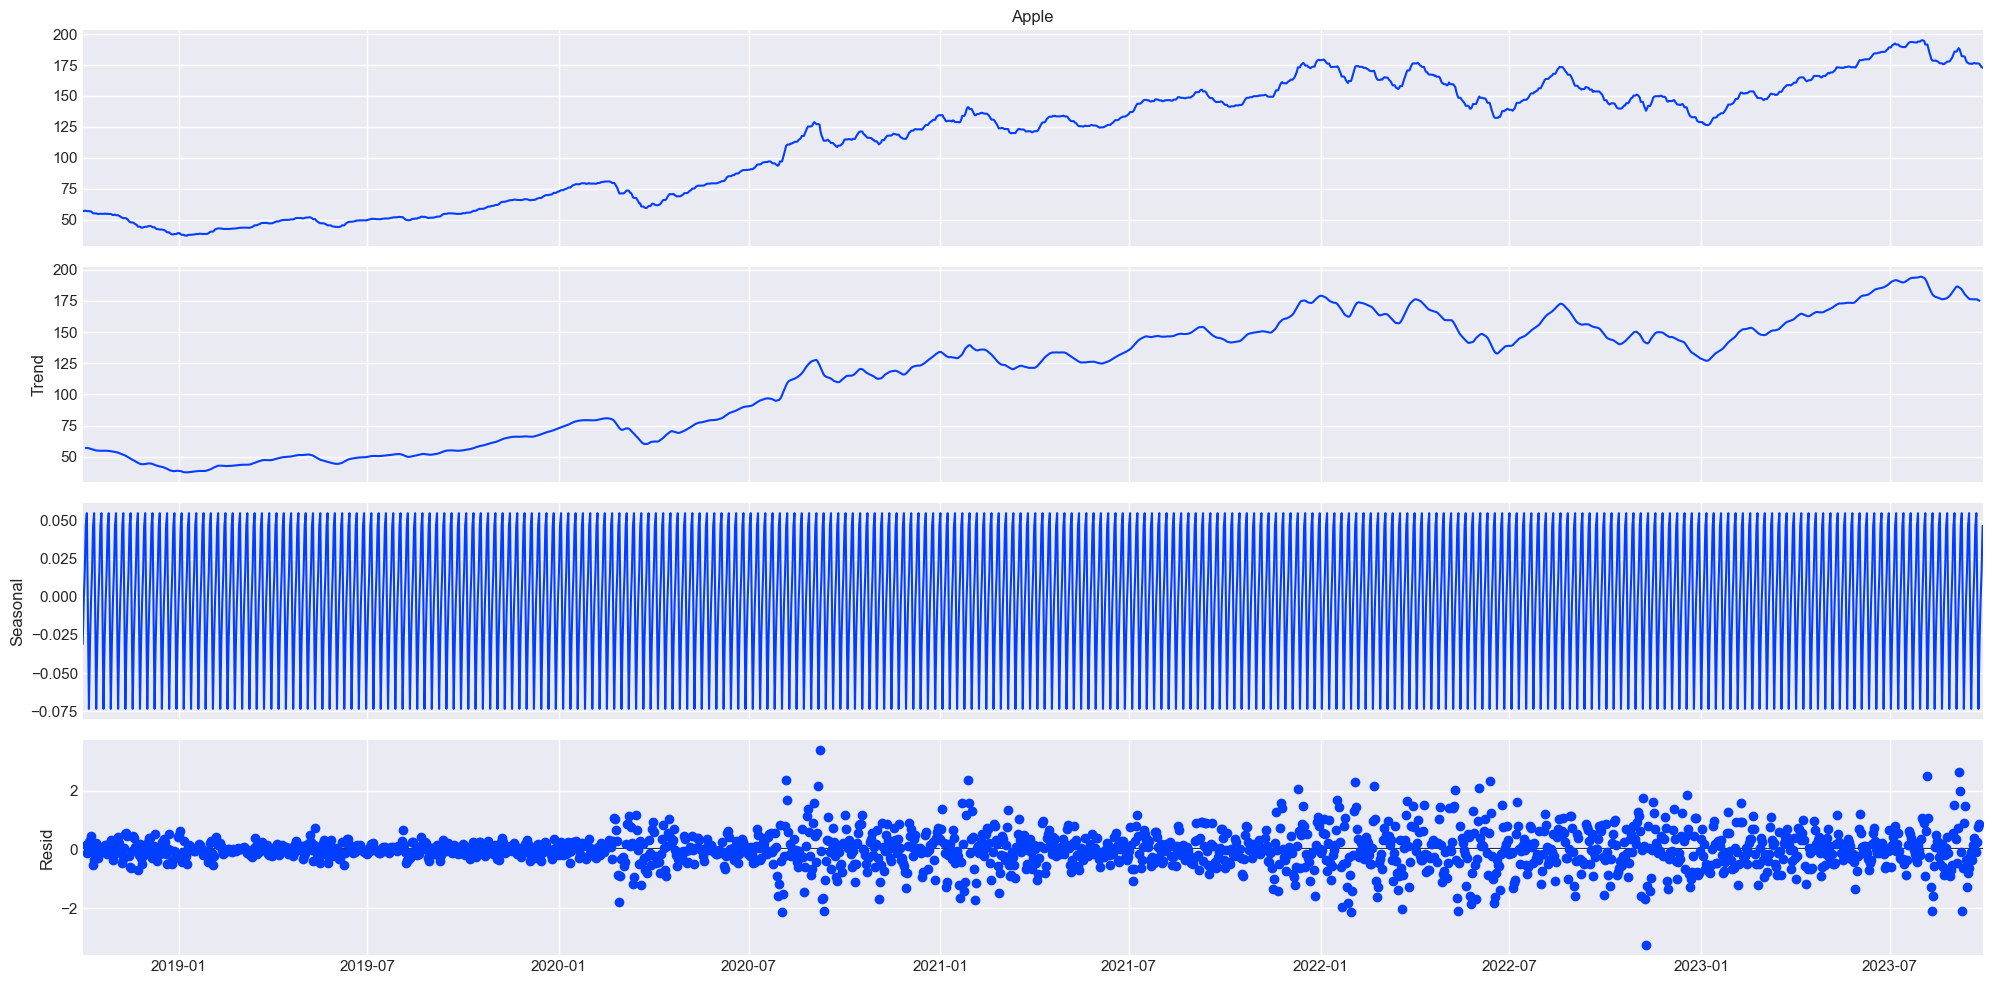

Seasonal Decomposition
Column: Amazon
Seasonal 7


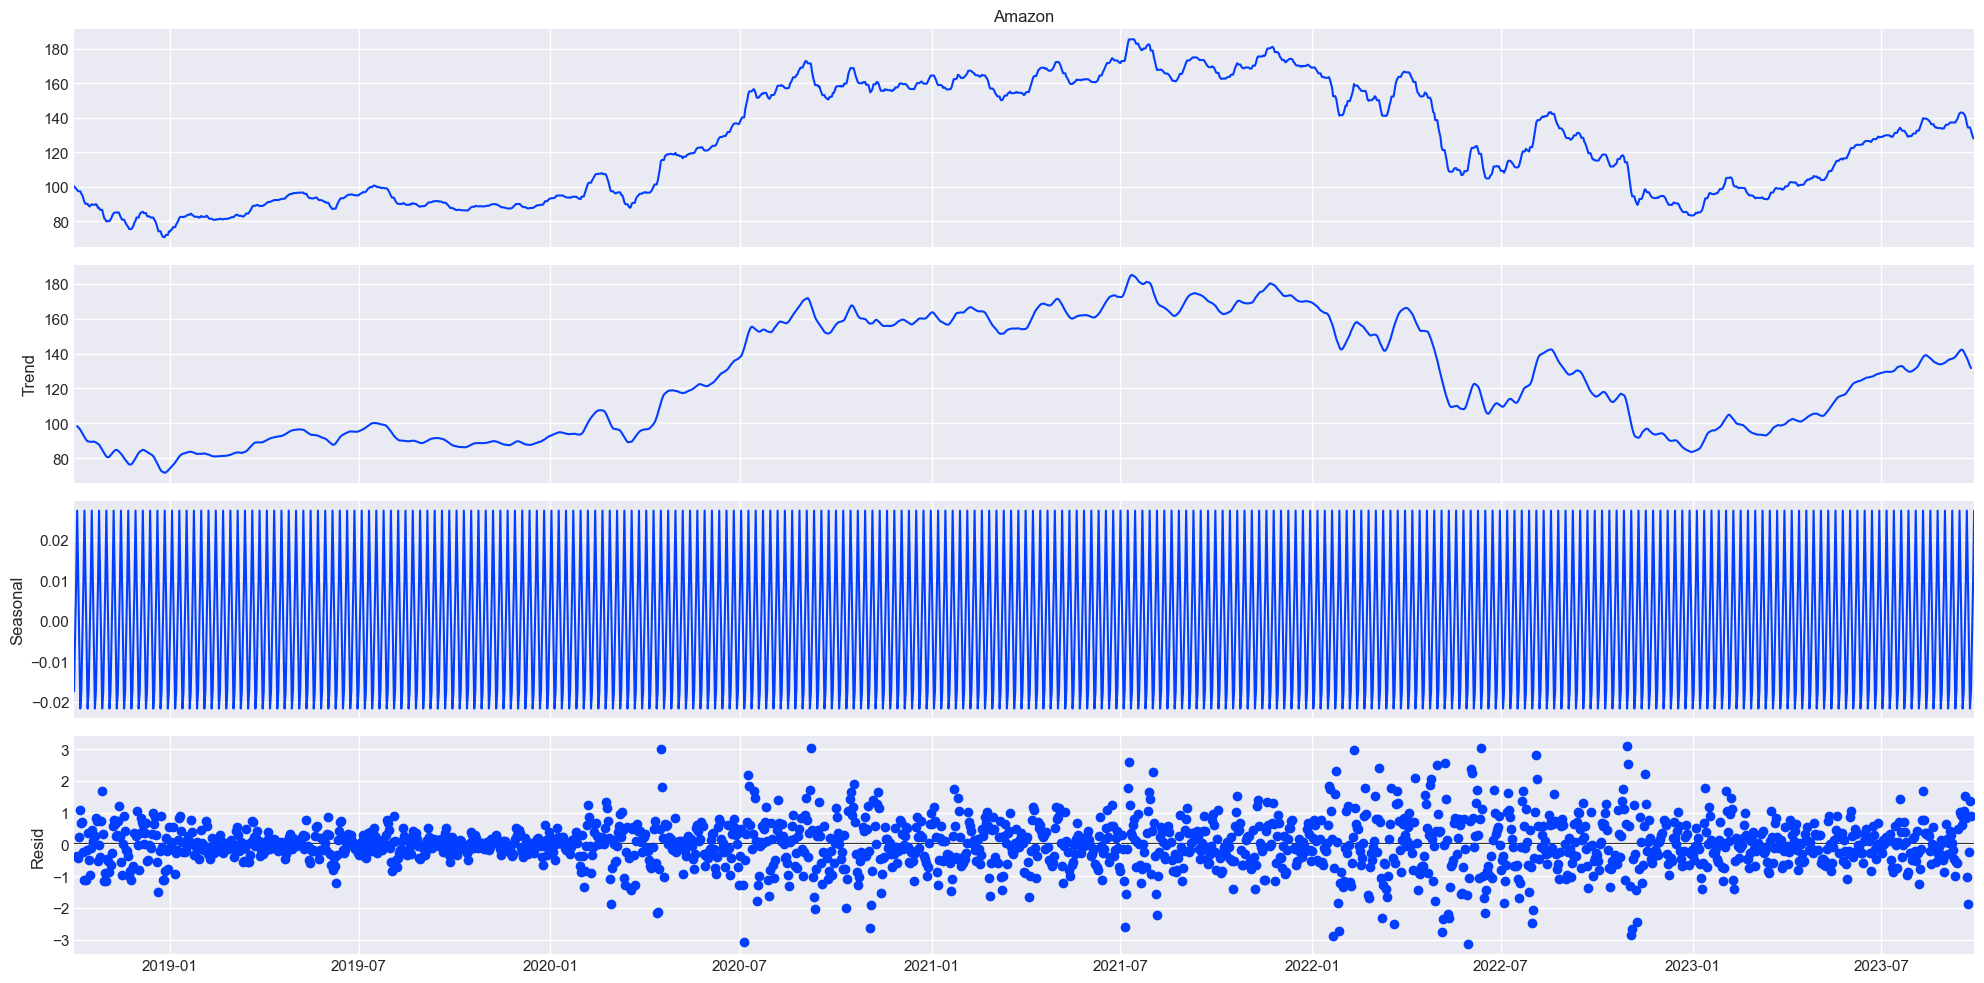

Seasonal Decomposition
Column: DBS
Seasonal 7


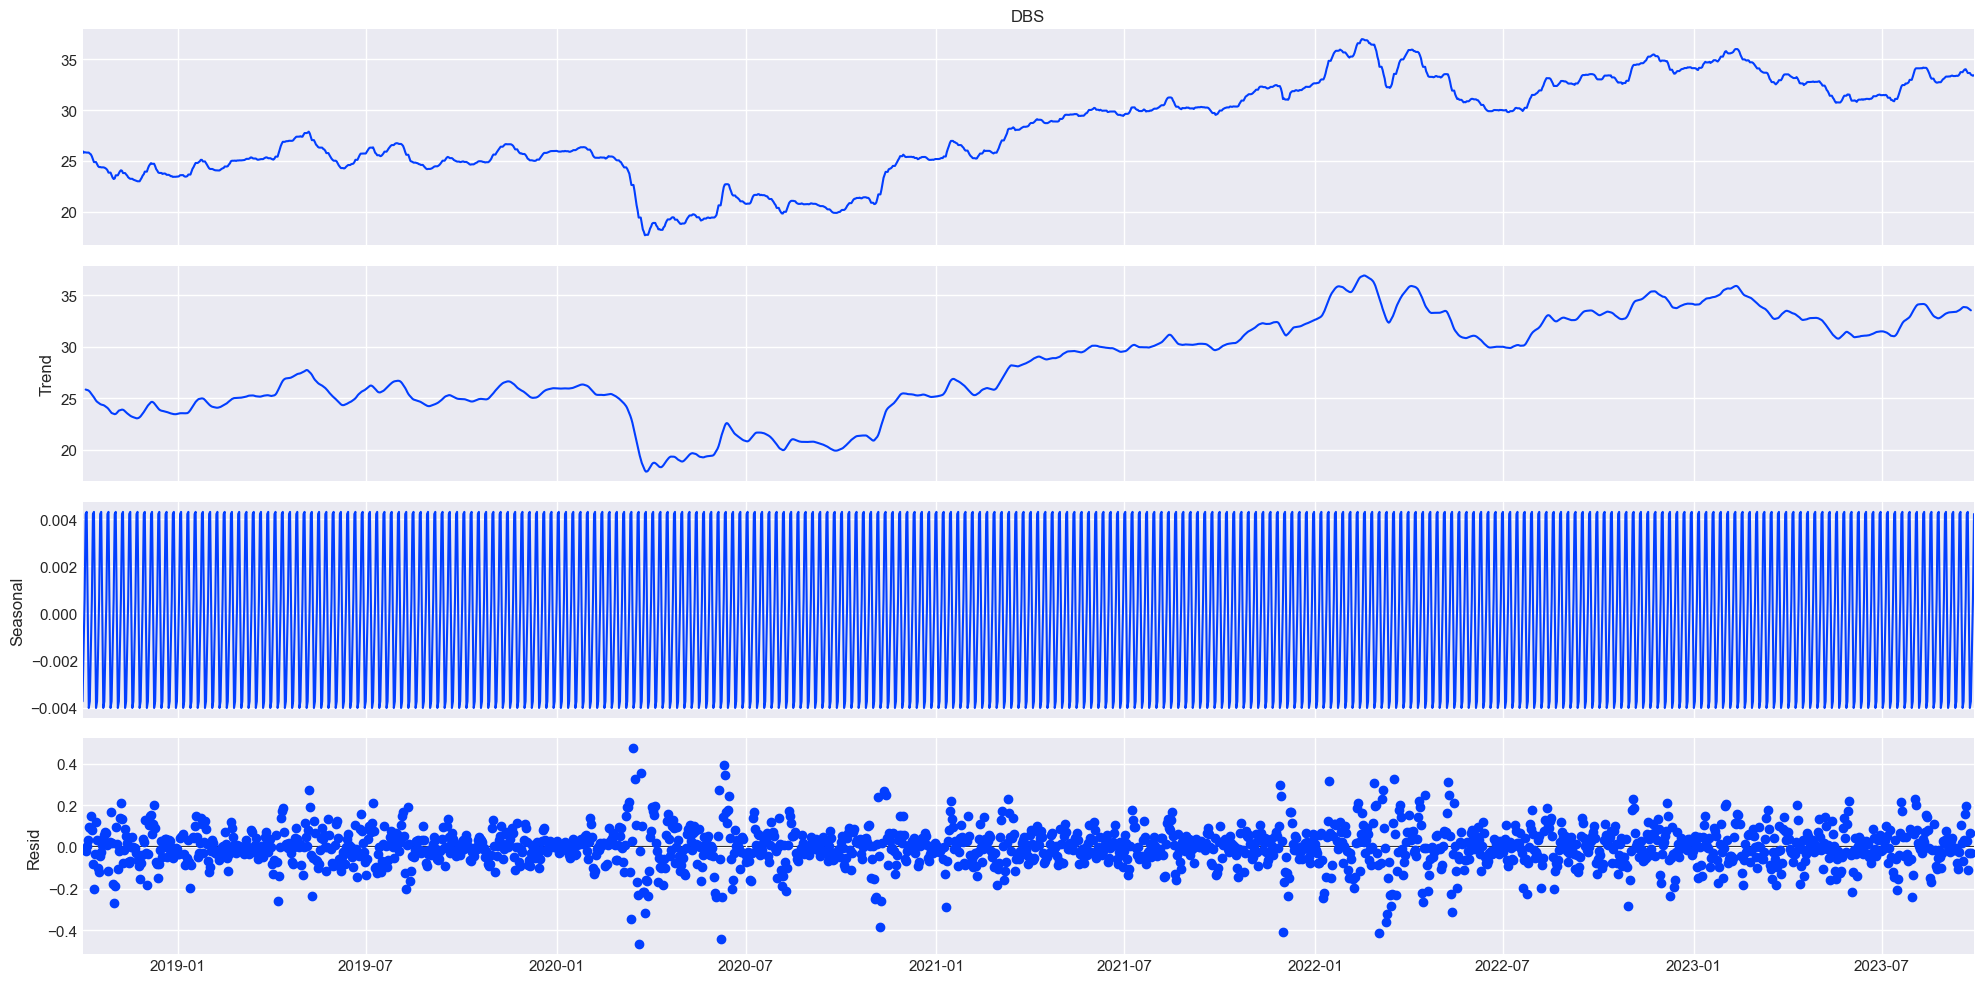

In [17]:
df = df.asfreq('D')
window_size = 7  # Define the window size for the rolling mean
df = df.rolling(window=window_size, min_periods=1).mean()

for i in df.columns:
    plt.rc("figure", figsize=(20, 10))
    print("Seasonal Decomposition\nColumn:", i)
    decomposition = seasonal_decompose(df[i], model='additive')
    print("Seasonal", len(decomposition.seasonal.drop_duplicates()))
    decomposition.plot()
    plt.show()

<b><u>Observations</u></b>

<ul>
<li>We can observe a upwards trends for all our features over the years</li>
<li>The seasonal periods are intervals of 7, and since our data freq is in day we will be assuming that it is a week. This will be important later on if there is a seasonality parameter</li>
</ul>

<hr>

## Ljung-Box and ADFuller Test

We will be doing Ljung-Box and ADFuller Test to check if autocorrelation exists in a time series

In [18]:
def ljungBoxTest(data, difference, color):
    # Create the line plot with style, colors, and labels
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Plot the time series series data
    axs[0].plot(data, color=color)
    axs[0].set_title('Time Series before differencing')

    # Plot the autocorrelation function
    plot_acf(data, ax=axs[2], title='ACF Plot before differencing')

    # Get the differenced
    if difference=="first":
        x_diff = data.diff().dropna()
    else:
        x_diff = np.log(data).diff().dropna()


    # Plot the time series series data
    axs[1].plot(x_diff, color=color)
    axs[1].set_title('Time Series after differencing')

    # Plot the autocorrelation function
    plot_acf(x_diff, ax=axs[3], title='ACF Plot after differencing')

    plt.suptitle(f'{col}')
    plt.tight_layout()
    plt.show()

    # ADF test for the original series
    adf_result_original = adfuller(df_eda[col])
    p_value_original = adf_result_original[1]

    # ADF test for the differenced series
    adf_result_differenced = adfuller(x_diff)
    p_value_differenced = adf_result_differenced[1]

    print(f"p-value original: {p_value_original}\np value after differencing: {p_value_differenced}")

    if p_value_differenced <= 0.05:
        print('After differencing, the series becomes stationary (p<=0.05)')
    else:
        print('After differencing, the series still is non-stationary (p>0.05)')

    # Ljung-Box test for the original series
    lb_result_original = acorr_ljungbox(data, lags=[20], return_df = True)
    single_p_value_original = lb_result_original['lb_pvalue'].iloc[0]


    lb_result_differenced = acorr_ljungbox(x_diff, lags=[20], return_df=True)
    single_p_value_differenced = lb_result_differenced['lb_pvalue'].iloc[0]

    print(f"\np-value of Ljung-Box Test Before differencing: {single_p_value_original}")
    print(f"p-value of Ljung-Box Test After differencing: {single_p_value_differenced:.2f}\n")
    
    
    if single_p_value_differenced <= 0.05:
        print("After differencing, the series's has autocorrelation as p-value < 0.05 (Reject H0)")
    else:
        print("After differencing, the series's autocorrelation is zero\n (i.e. has no autocorrelations) as p-value >= 0.05 (fail to reject H0)")

In [19]:
def differencingPlot(data, color):
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)
    plt.plot(data, color=color)
    plt.title('Original Apple Column')

    plt.subplot(1, 3, 2)
    plt.plot(data.diff(), color=color)
    plt.title('First Difference')

    plt.subplot(1, 3, 3)
    plt.plot(np.log(data).diff(), color=color)
    plt.title('Log and First Difference')

    plt.tight_layout()
    plt.show()

<u>Ljung Box Test for Apple</u>

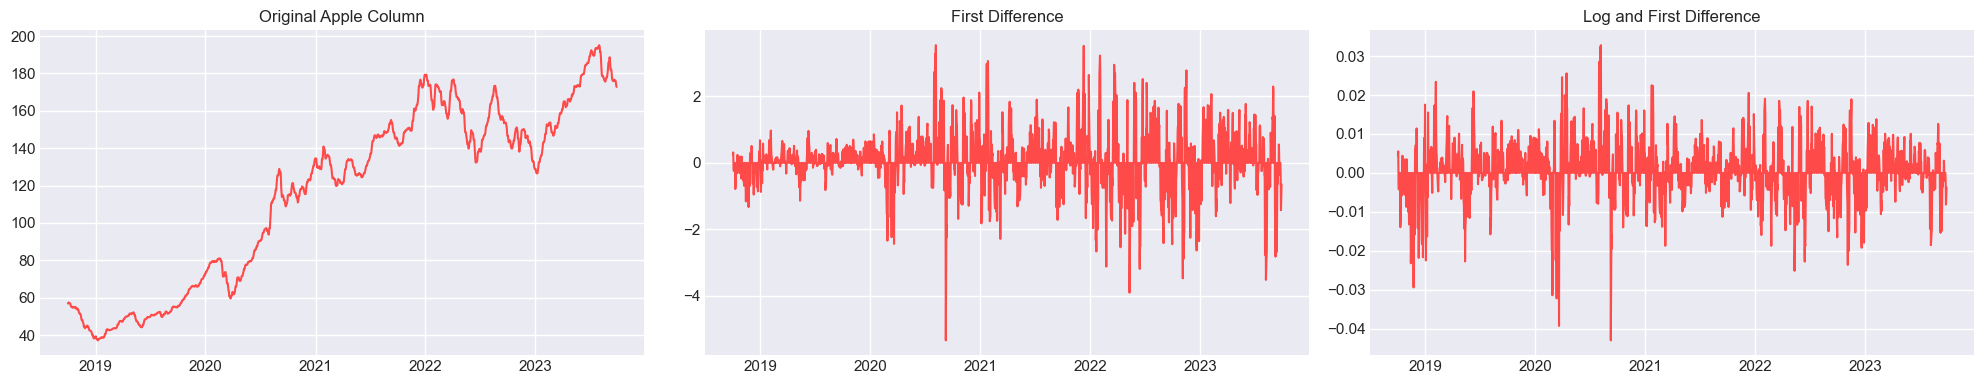

In [20]:
differencingPlot(df['Apple'], colors[0])

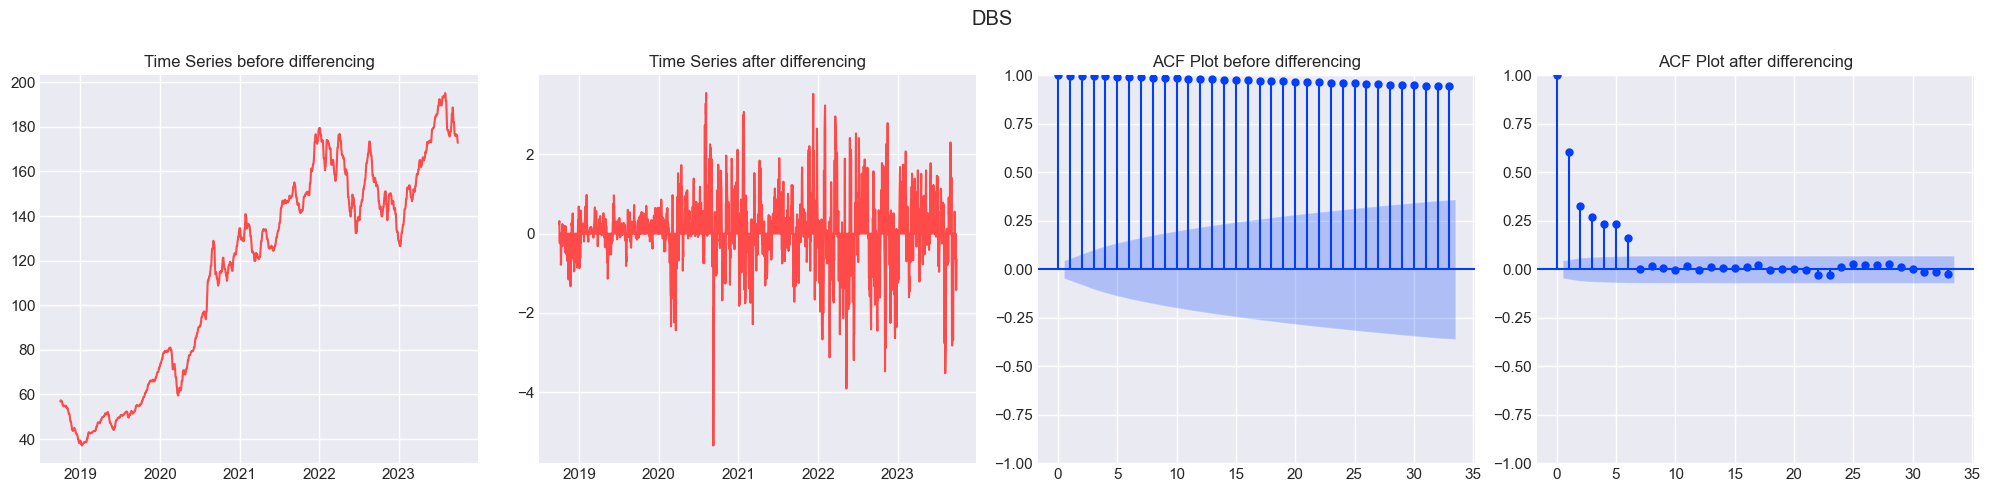

p-value original: 0.6556796201732027
p value after differencing: 3.4399824056453765e-15
After differencing, the series becomes stationary (p<=0.05)

p-value of Ljung-Box Test Before differencing: 0.0
p-value of Ljung-Box Test After differencing: 0.00

After differencing, the series's has autocorrelation as p-value < 0.05 (Reject H0)


In [21]:
ljungBoxTest(df['Apple'], 'first', colors[0])

<u>Ljung Box Test for Amazon</u>

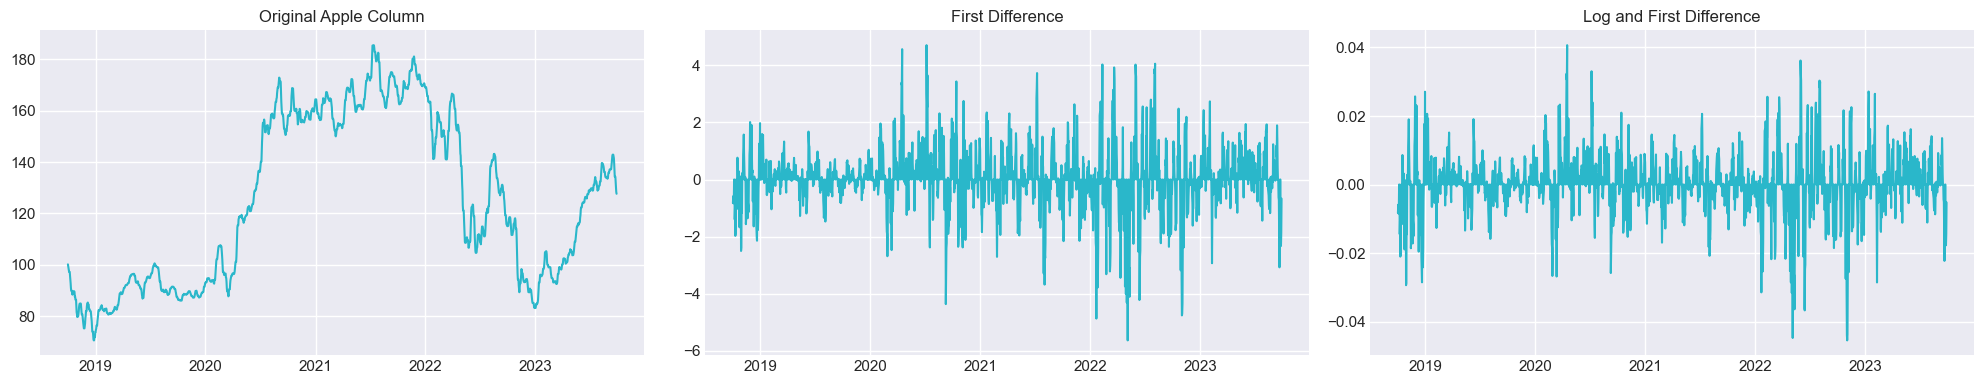

In [22]:
differencingPlot(df['Amazon'], colors[1])

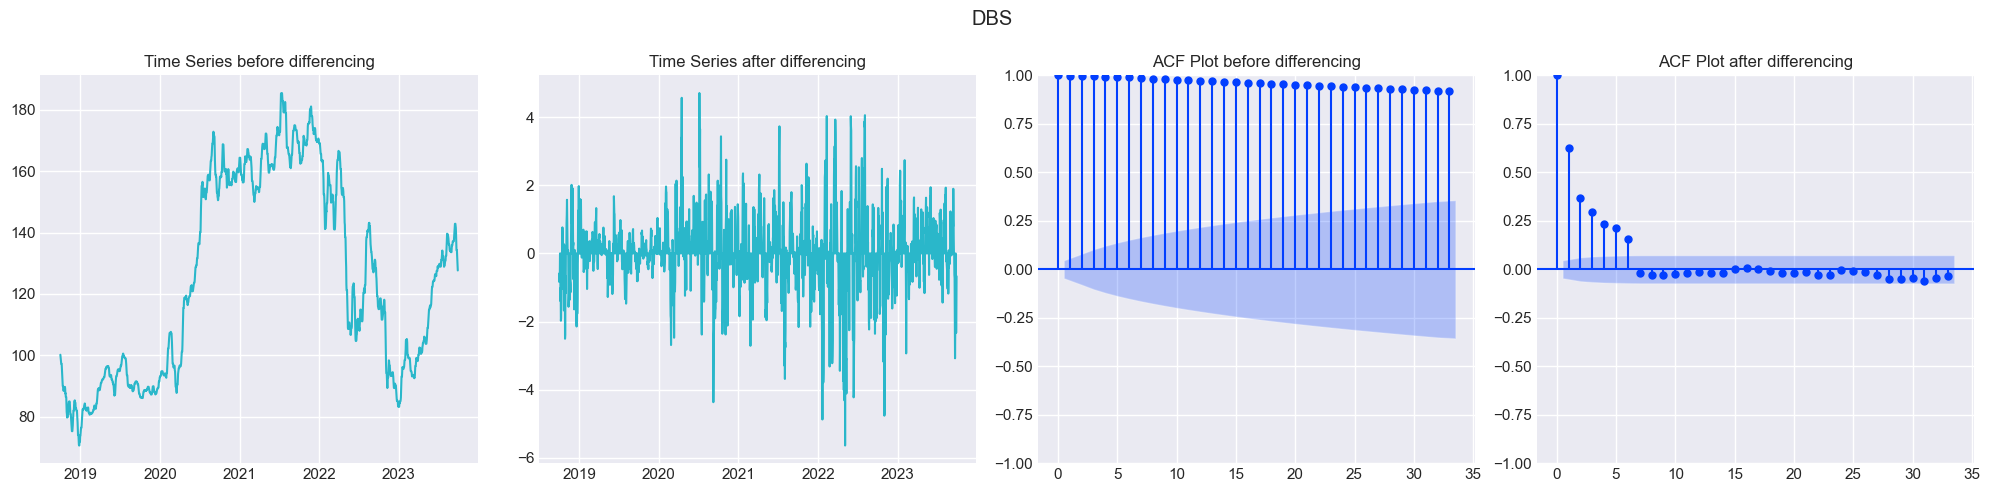

p-value original: 0.6556796201732027
p value after differencing: 9.854133579403654e-17
After differencing, the series becomes stationary (p<=0.05)

p-value of Ljung-Box Test Before differencing: 0.0
p-value of Ljung-Box Test After differencing: 0.00

After differencing, the series's has autocorrelation as p-value < 0.05 (Reject H0)


In [27]:
ljungBoxTest(df['Amazon'], 'first', colors[1])

<u>Ljung Box Test for DBS</u>

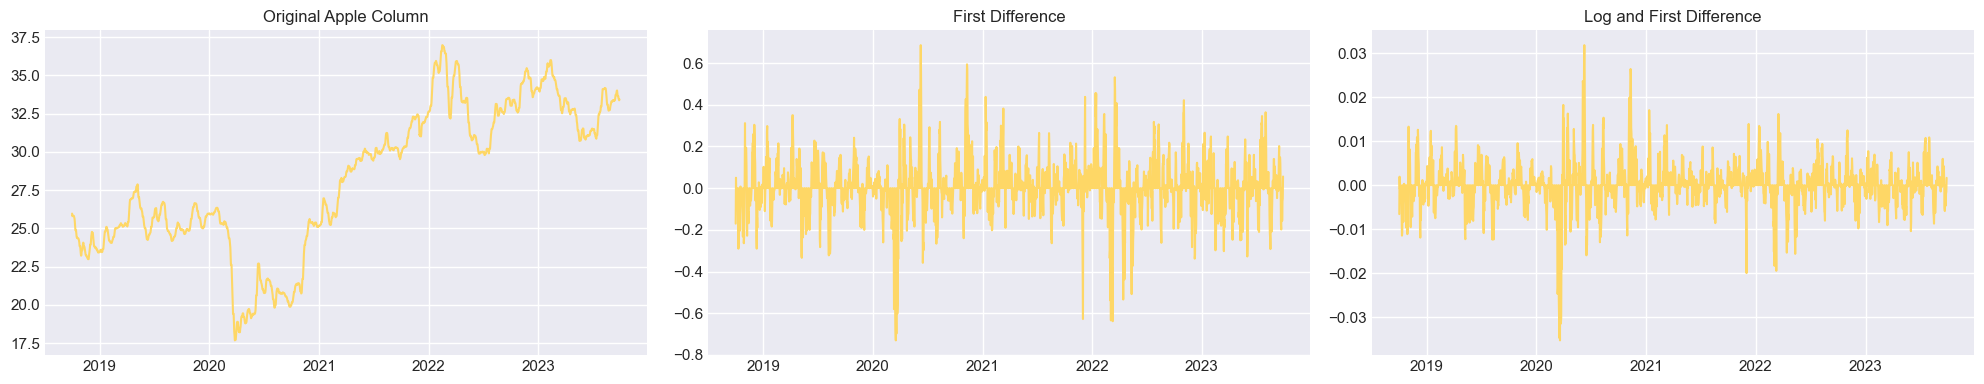

In [24]:
differencingPlot(df['DBS'], colors[2])

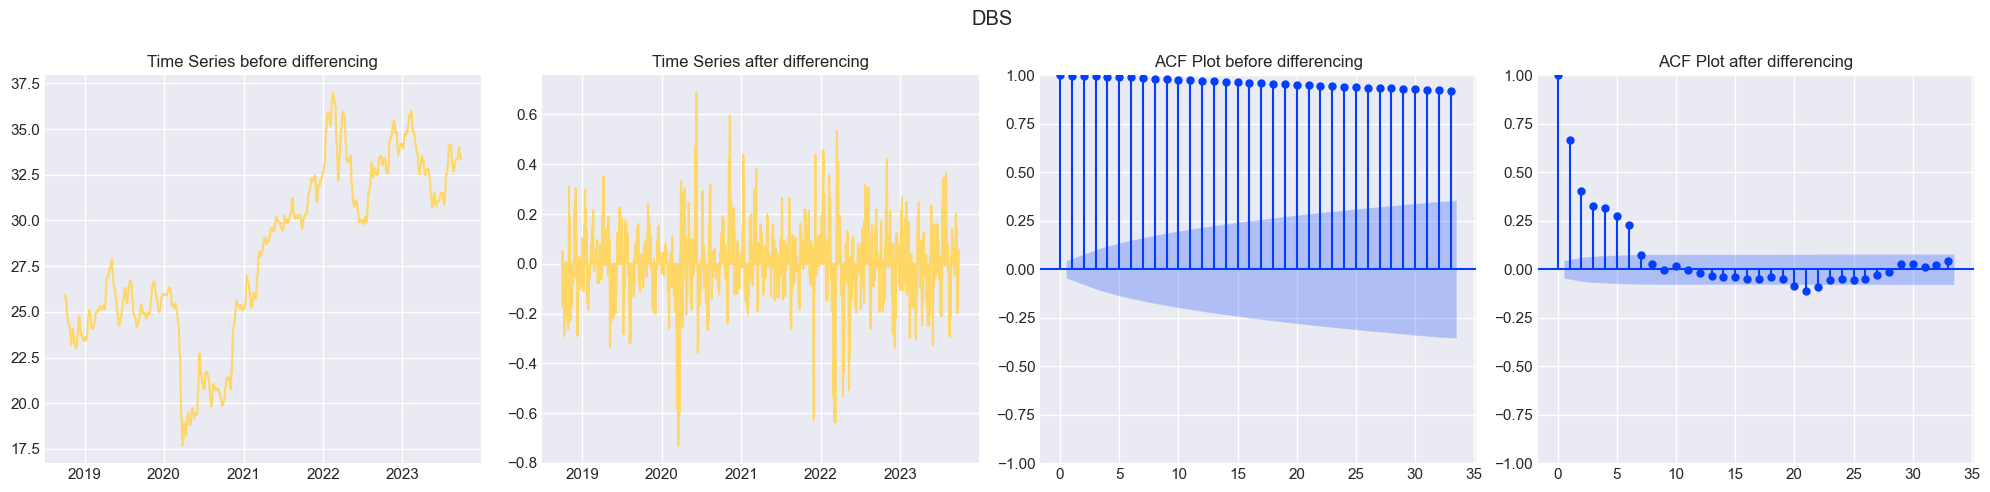

p-value original: 0.6556796201732027
p value after differencing: 7.047765977957725e-16
After differencing, the series becomes stationary (p<=0.05)

p-value of Ljung-Box Test Before differencing: 0.0
p-value of Ljung-Box Test After differencing: 0.00

After differencing, the series's has autocorrelation as p-value < 0.05 (Reject H0)


In [26]:
ljungBoxTest(df['DBS'], 'first', colors[2])

<hr>

### ACF and PACF Analysis

Autocorrelation analysis looks at how a series relates to its past values over time. It uses tools like ACF and PACF.

ACF measures similarity between a series and its past.<br>
PACF does the same but considers only direct relationships, not others.
These tools help us understand data patterns and decide how many past values to include in models like AR and MA.

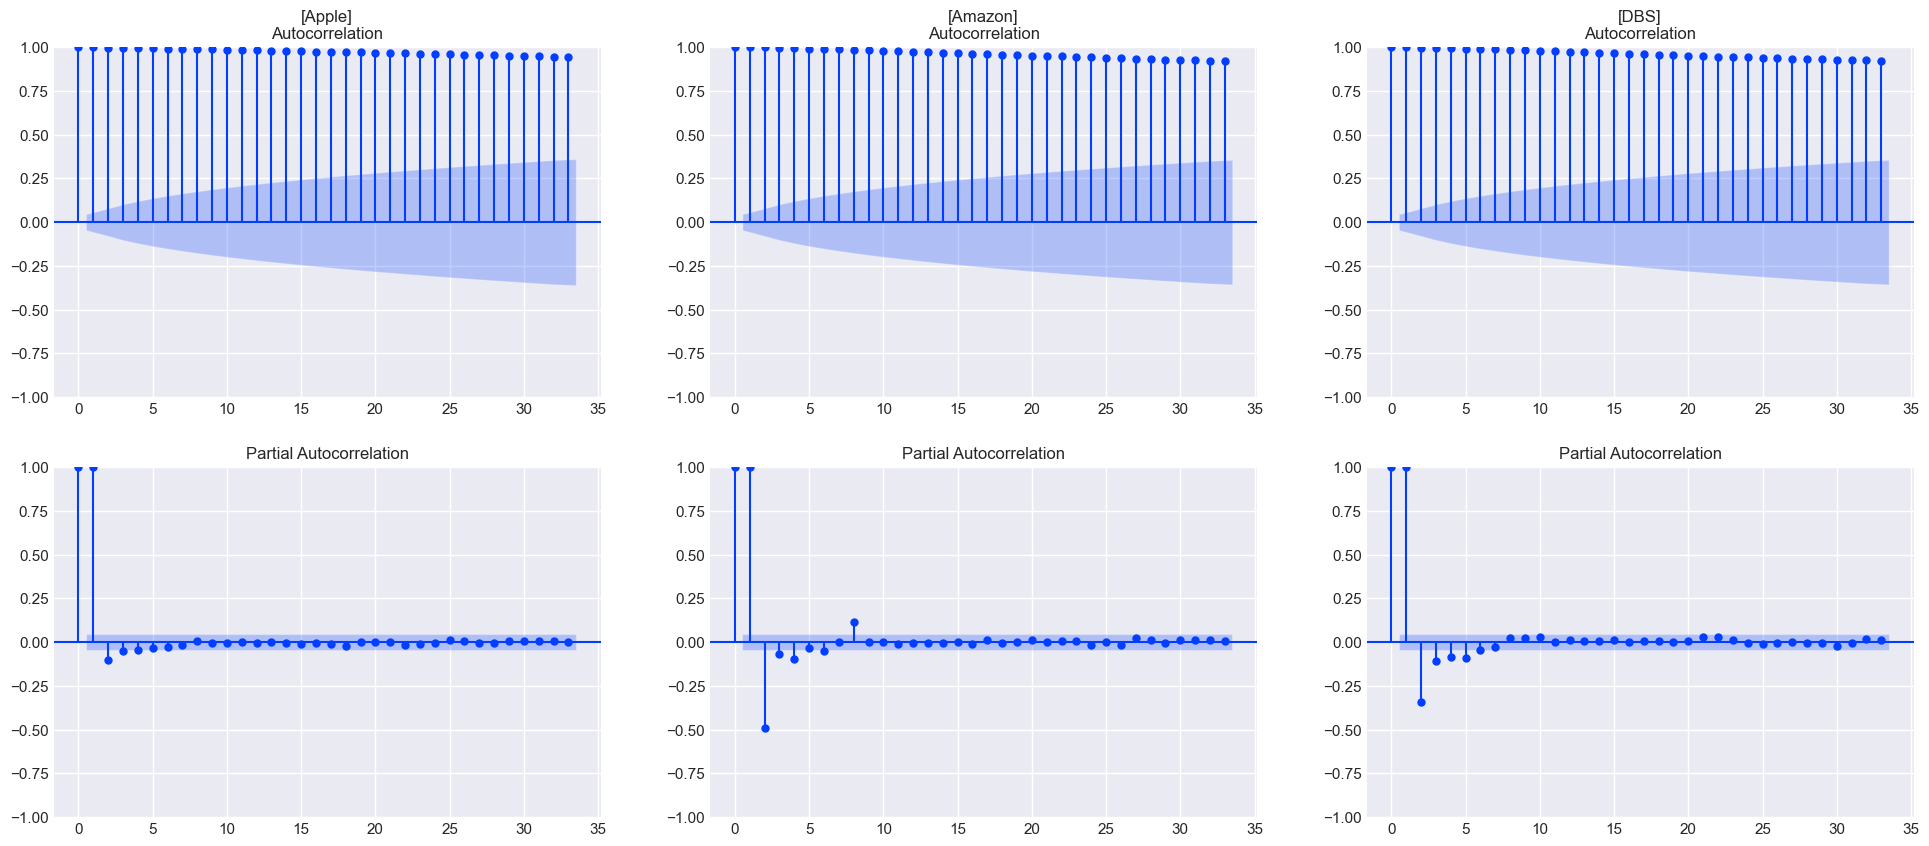

In [33]:
# Autocorrelation and Partial Autocorrelation
fig, axes = plt.subplots(2,3, figsize = (24,10))
for idx, variable in enumerate(df):
    plot_acf(df[variable], ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(df[variable], method='ywm', ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation".format(variable))
plt.show()

#### Summary

##### <u>ACF</u>:<br>
We can see that the ACF is showing that it is consistently decreasing slowly over time and that the coeffecient is signifcantly high. This suggests that all 3 columns are non-stationary.


##### <u>PACF:</u><br>
Amazon & DBS:

 A high partial autocorrelation at the second lag indicates that the current observation is strongly influenced not only by the immediately preceding observation but also by the observation two time points earlier. This suggests that the time series may require an AR model with additional lags to adequately capture its autocorrelation structure

Apple:

 Unlike Amazon & DBS it has autocorrelation at the second lag but not as high of a coeffecient

<hr>

### Sampling Technique
<hr>

The Expanding Window technique trains and tests a model several times using different parts of the dataset. It starts with a small portion and gradually includes more data with each iteration. This helps the model learn from various parts of the dataset and capture different patterns and trends. 

We will be splitting the test data into 80% and 20%

In [20]:
# Split data into train and test
train_data = df.iloc[:-365]
test_data = df.iloc[-365:]

# Function to evaluate model
def expanding_window(model, endog, test_size=365, n_splits=3, **kwargs):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    rmse_hist = []
    mape_hist = []
    aic_hist = []
    for idx, (train_index, test_index) in enumerate(tscv.split(endog)):
        warnings.filterwarnings("ignore")
        res = model(endog.iloc[train_index], **kwargs).fit()
        yhat = res.forecast(test_size)
        ytrue = endog.iloc[test_index]
        rmse_hist.append(mean_squared_error(ytrue, yhat, squared=False))
        mape_hist.append(mean_absolute_percentage_error(ytrue, yhat))
        aic_hist.append(res.aic)
    return np.array(rmse_hist).mean(), np.array(mape_hist).mean(), np.array(aic_hist).mean()

<hr>

### Model
<hr>

We will be creating a baseline model which serves as a benchmark against which the performance of more complex models can be compared. The baseline model we will use is a straightforward Average Forecast method which predicts the current observation by taking the mean of historical data.

In [21]:
def expanding_window_baseline(endog:pd.Series, test_size=365, n_splits=3):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    rmse_hist = []
    mape_hist = []
    
    """For each iteration of the time series split, the training data is used to compute the mean value. 
    This mean value serves as the forecast for all observations in the corresponding test set."""

    for iters, (train_index, test_index) in enumerate(tscv.split(endog)):     
        train = endog.iloc[train_index]
        test = endog.iloc[test_index]
        yhat = pd.Series(train.mean()).repeat(test_size)
        
        rmse_hist.append(mean_squared_error(test.values, yhat.values, squared=False))
        mape_hist.append(mean_absolute_percentage_error(test.values, yhat.values))

    return np.array(rmse_hist).mean(), np.array(mape_hist).mean()

base_hist = dict()
for var in df.columns:
    base_hist[var] = expanding_window_baseline(endog=train_data[var])

pd.DataFrame(base_hist, index = ['baseline_rmse', 'baseline_mape']).T

,baseline_rmse,baseline_mape
Apple,59.418635,0.444900
Amazon,44.533348,0.250056
DBS,5.390316,0.173763


<hr>


#### ARIMA

 ARIMA stands for Autoregressive Integrated Moving Average, it is a popular time series forecasting model used to predict future values based on past data. It combines three key components: autoregressive (AR), moving average (MA), and differencing.

 Since we know that the time sereis is non-stationary and we need to get the first difference from the LjunBoxTest we can set the d parameter to 1 to get the first difference

In [34]:
arima_apple_results = dict()

for p in tqdm(range(10)):
    for q in range(10):
            rmse, mape, aic = expanding_window(ARIMA, train_data['Apple'], order=(p,1,q))
            arima_apple_results['({},{},{})'.format(p,1,q)] = [rmse, mape, aic]
            
pd.DataFrame(arima_apple_results).T.rename(columns = {0:"RMSE", 1:"MAPE", 2:"AIC"}).sort_values(["MAPE"]).head(10)

 10%|█         | 1/10 [00:05<00:49,  5.55s/it]

100%|██████████| 10/10 [04:39<00:00, 27.99s/it]


,RMSE,MAPE,AIC
"(3,1,9)",21.221289,0.151859,878.866488
"(5,1,9)",22.616802,0.161758,879.784471
"(2,1,8)",23.438538,0.165909,880.531792
"(3,1,7)",23.534793,0.168417,880.225933
"(1,1,8)",23.547457,0.168501,883.930677
"(5,1,2)",23.601415,0.169010,897.894850
"(7,1,0)",23.549499,0.169193,895.284456
"(7,1,1)",23.595328,0.169532,885.286398
"(6,1,1)",23.581135,0.169614,903.484332
"(3,1,8)",23.610100,0.169686,879.788000


In [35]:
arima_amazon_results = dict()

for p in tqdm(range(10)):
    for q in range(10):
            rmse, mape, aic = expanding_window(ARIMA, train_data['Amazon'], order=(p,1,q))
            arima_amazon_results['({},{},{})'.format(p,1,q)] = [rmse, mape, aic]
            
pd.DataFrame(arima_amazon_results).T.rename(columns = {0:"RMSE", 1:"MAPE", 2:"AIC"}).sort_values(["MAPE"]).head(10)

100%|██████████| 10/10 [04:18<00:00, 25.83s/it]


,RMSE,MAPE,AIC
"(2,1,9)",26.623750,0.144336,1409.285853
"(3,1,8)",26.802140,0.145416,1408.621520
"(4,1,8)",26.879732,0.145901,1410.238087
"(5,1,8)",26.898438,0.146197,1411.870937
"(6,1,3)",26.760696,0.146234,1419.267182
"(4,1,4)",26.795577,0.146297,1430.399378
"(9,1,9)",26.787341,0.146526,1416.528206
"(3,1,4)",26.835729,0.146589,1431.838378
"(6,1,1)",26.839992,0.146905,1427.812289
"(6,1,2)",26.852091,0.146993,1426.112484


In [36]:
arima_dbs_results = dict()

for p in tqdm(range(10)):
    for q in range(10):
            rmse, mape, aic = expanding_window(ARIMA, train_data['DBS'], order=(p,1,q))
            arima_dbs_results['({},{},{})'.format(p,1,q)] = [rmse, mape, aic]
            
pd.DataFrame(arima_dbs_results).T.rename(columns = {0:"RMSE", 1:"MAPE", 2:"AIC"}).sort_values(["MAPE"]).head(10)

100%|██████████| 10/10 [04:58<00:00, 29.86s/it]


,RMSE,MAPE,AIC
"(9,1,1)",4.932082,0.158567,-1424.881481
"(9,1,3)",4.932198,0.158573,-1423.845050
"(9,1,9)",4.930189,0.158581,-1415.034184
"(9,1,0)",4.933436,0.158588,-1419.987453
"(9,1,8)",4.931522,0.158627,-1415.672419
"(7,1,9)",4.932487,0.158646,-1420.450221
"(6,1,8)",4.932815,0.158667,-1423.590533
"(9,1,2)",4.934877,0.158676,-1426.035237
"(9,1,4)",4.932319,0.158702,-1422.927466
"(5,1,8)",4.934558,0.158723,-1425.835425


ARIMA Model:<br>
|   Company  | Parameters |    RMSE   |   MAPE   |      AIC       |
|:----------:|:----------:|:---------:|:--------:|:--------------:|
|   Apple    | (3, 1, 9)  | 21.221289 | 0.151859 |   878.866488   |
|   Amazon   | (2, 1, 9)  | 26.623750 | 0.144336 |   1409.285853  |
|    DBS     | (9, 1, 1)  |  4.932082 | 0.158567 |   -1424.881481 |


Baseline Model: <Br>
| Company | baseline_rmse | baseline_mape |
|---------|---------------|---------------|
| Apple   |   59.418635   |    0.444900   |
| Amazon  |   44.533348   |    0.250056   |
| DBS     |    5.390316   |    0.173763   |


As we can see the MAPE for all 3 columns are bettelower than the basline model which indicates that our ARIMA Model has performed better which is expected

Now we will be visualissing the model the see how it performed. We will be using the 365 days to get a rough idea of how the model performed which is 20% of the data.

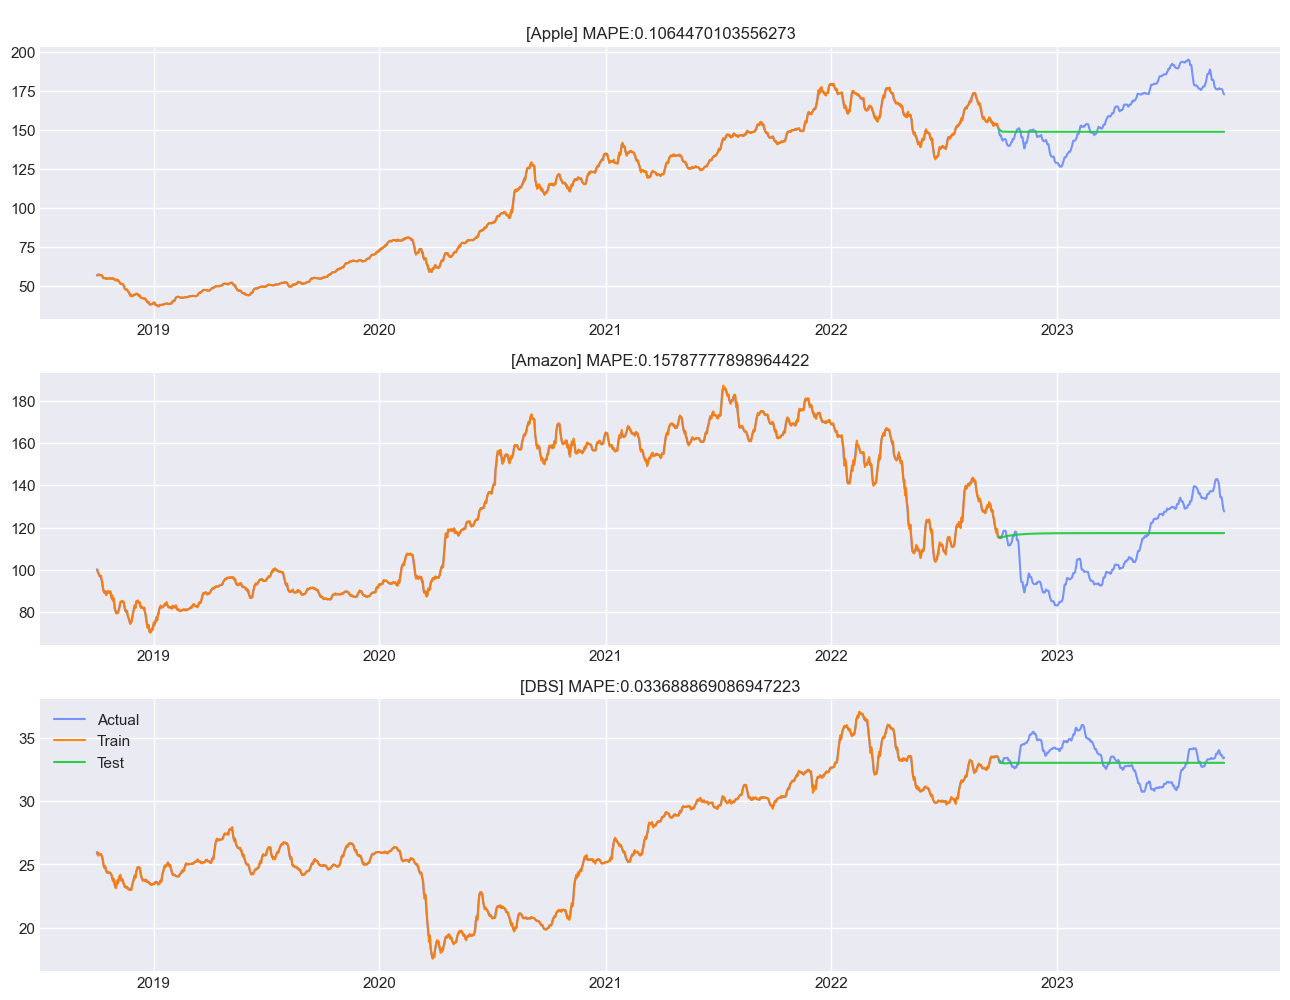

In [55]:
orders = [(3,1,9),(2,1,9),(9,1,1)]

fig, axes = plt.subplots(3,1, figsize=(16, 12))

for idx, order in enumerate(orders):
    mod = ARIMA(train_data[df.columns[idx]], order = order)
    res = mod.fit()

    full_pred = res.predict()
    pred = res.forecast(365)

    axes[idx].set_title("\n[{}] MAPE:{}".format(df.columns[idx], mean_absolute_percentage_error(test_data[df.columns[idx]],pred)))
    axes[idx].plot(df[df.columns[idx]], label = 'Actual', alpha=0.5)
    axes[idx].plot(full_pred.iloc[1:], label = 'Train', alpha=0.9)
    axes[idx].plot(pred, label='Test', alpha=0.9)
plt.legend()
plt.show()

<u>Observation</u>

We can see from the visualisation that the ARIMA model is just following a straight horizontal line from the last point. Overall, the model is not very good at forecasting the stock.

<hr>

### SARIMA

Seasonal ARIMA (SARIMA) extends the capabilities of the ARIMA model by incorporating seasonality into time series forecasting

Similar to ARIMA, SARIMA also involves setting the differencing parameter to 1 when dealing with non-stationary time series data



In [38]:
sarima_apple_results = dict()

# Define Params Space
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)
P_range = range(1,3)
D_range = [1]
Q_range = range(1,3)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_mape_aic_tuple = expanding_window(SARIMAX, train_data["Apple"], order = (p,d,q), seasonal_order=(P,D,Q,m))
        sarima_apple_results[f'({p},{d},{q}),({P},{D},{Q},{m})'] = rmse_mape_aic_tuple
    except:
        continue

pd.DataFrame(sarima_apple_results, index=['rmse','mape' ,'aic']).T.sort_values(['mape']).head(10)


36it [05:28,  9.11s/it]


,rmse,mape,aic
"(1,1,3),(2,1,2,7)",12.327619,0.088538,918.915996
"(1,1,3),(1,1,2,7)",12.434712,0.088603,918.566488
"(1,1,3),(1,1,1,7)",12.423986,0.088896,916.762744
"(1,1,3),(2,1,1,7)",12.603659,0.090463,918.407288
"(2,1,3),(2,1,2,7)",15.033703,0.104141,912.085713
"(2,1,3),(1,1,2,7)",15.422984,0.106797,911.357433
"(2,1,1),(2,1,2,7)",15.942469,0.107628,925.332429
"(2,1,1),(1,1,1,7)",16.043509,0.108087,923.275889
"(3,1,2),(2,1,2,7)",15.662440,0.108660,907.705722
"(2,1,1),(2,1,1,7)",16.044526,0.108972,925.033587


In [39]:
sarima_amazon_results = dict()

# Define Params Space
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)
P_range = range(1,3)
D_range = [1]
Q_range = range(1,3)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_mape_aic_tuple = expanding_window(SARIMAX, train_data["Amazon"], order = (p,d,q), seasonal_order=(P,D,Q,m))
        sarima_amazon_results[f'({p},{d},{q}),({P},{D},{Q},{m})'] = rmse_mape_aic_tuple
    except:
        continue

pd.DataFrame(sarima_amazon_results, index=['rmse','mape' ,'aic']).T.sort_values(['mape']).head(10)

36it [05:34,  9.30s/it]


,rmse,mape,aic
"(3,1,2),(1,1,2,7)",31.144287,0.179266,1443.834229
"(3,1,3),(1,1,2,7)",33.840525,0.196287,1438.863199
"(1,1,3),(1,1,2,7)",34.167266,0.199443,1440.127471
"(2,1,3),(1,1,2,7)",34.381481,0.200600,1441.790345
"(3,1,3),(1,1,1,7)",38.287270,0.219414,1441.360629
"(2,1,1),(2,1,2,7)",38.456128,0.220206,1450.129328
"(3,1,1),(2,1,2,7)",38.667425,0.221539,1438.946746
"(2,1,3),(2,1,2,7)",38.664664,0.221780,1439.416938
"(2,1,2),(2,1,2,7)",38.661488,0.221916,1437.440327
"(1,1,1),(2,1,2,7)",38.732123,0.222167,1452.946452


In [40]:
sarima_dbs_results = dict()

# Define Params Space
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)
P_range = range(1,3)
D_range = [1]
Q_range = range(1,3)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_mape_aic_tuple = expanding_window(SARIMAX, train_data["DBS"], order = (p,d,q), seasonal_order=(P,D,Q,m))
        sarima_dbs_results[f'({p},{d},{q}),({P},{D},{Q},{m})'] = rmse_mape_aic_tuple
    except:
        continue

pd.DataFrame(sarima_dbs_results, index=['rmse','mape' ,'aic']).T.sort_values(['mape']).head(10)

36it [05:47,  9.64s/it]


,rmse,mape,aic
"(2,1,1),(1,1,1,7)",3.147444,0.100961,-1266.630995
"(2,1,1),(2,1,1,7)",3.819954,0.107479,-1264.065420
"(2,1,3),(2,1,1,7)",5.094527,0.163022,-1359.056007
"(1,1,3),(2,1,1,7)",5.126436,0.163639,-1344.062442
"(3,1,3),(2,1,1,7)",5.108042,0.163737,-1355.458206
"(1,1,2),(1,1,2,7)",5.128301,0.164449,-1342.872292
"(2,1,2),(2,1,1,7)",5.143226,0.164452,-1343.479874
"(1,1,2),(1,1,1,7)",5.156958,0.164703,-1347.095572
"(3,1,1),(2,1,1,7)",5.161648,0.164985,-1349.397204
"(3,1,2),(1,1,1,7)",5.164406,0.165055,-1331.904103


SARIMA Model:<br>
|   Company  | Parameters        |    RMSE    |   MAPE    |      AIC       |
|:----------:|:-----------------:|:----------:|:---------:|:--------------:|
|   Apple    | (1, 1, 3), (2, 1, 2, 7)  |  12.327619 |  0.088538 |   918.915996   |
|   Amazon   | (3, 1, 2), (1, 1, 2, 7)  |  31.144287 |  0.179266 |  1443.834229   |
|    DBS     | (2, 1, 1), (1, 1, 1, 7)  |   3.147444 |  0.100961 |  -1266.630995  |


Baseline Model: <Br>
| Company | baseline_rmse | baseline_mape |
|---------|---------------|---------------|
| Apple   |   59.418635   |    0.444900   |
| Amazon  |   44.533348   |    0.250056   |
| DBS     |    5.390316   |    0.173763   |

Our SARIMA Model performed better than the Baseline model as we can see the MAPE is lower in all columns. It performed better than ARIMA for Apple and DBS where the MAPE is lowerbut did not perform better for Amazon.

Now we will be visualissing the model the see how it performed. We will be using the 365 days to get a rough idea of how the model performed which is 20% of the data.

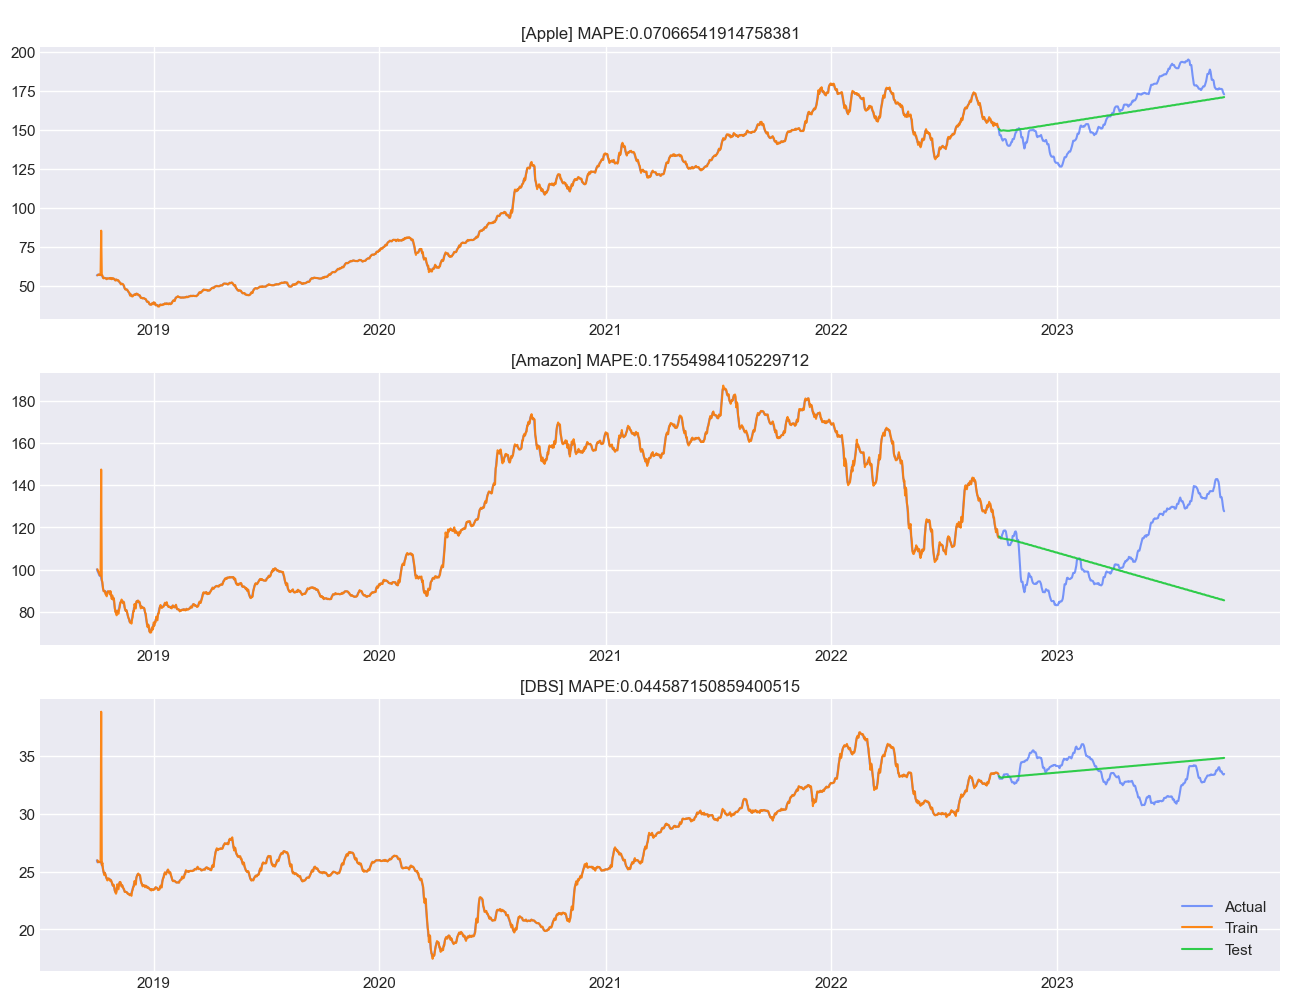

In [56]:
orders = [((1,1,3),(2,1,2,7)),((3,1,2),(1,1,2,7)),((2,1,1),(1,1,1,7))]

fig, axes = plt.subplots(3,1, figsize=(16, 12))

for idx, (order, seasonal_order) in enumerate(orders):
    mod = SARIMAX(train_data[df.columns[idx]], order = order, seasonal_order = seasonal_order)
    res = mod.fit()

    full_pred = res.predict()
    pred = res.forecast(365)

    axes[idx].set_title("\n[{}] MAPE:{}".format(df.columns[idx], mean_absolute_percentage_error(test_data[df.columns[idx]],pred)))
    axes[idx].plot(df[df.columns[idx]], label = 'Actual', alpha=0.5)
    axes[idx].plot(full_pred.iloc[1:], label = 'Train', alpha=0.9)
    axes[idx].plot(pred, label='Test', alpha=0.9)
plt.legend()
plt.show()

<hr>

### Holt-Winter Exp Smoothing

Holt-Winters Seasonal Exponential Smoothing is a powerful technique for time series forecasting that considers both trends and seasonality in the data

Unlike some other forecasting methods, Holt-Winters doesn't require tuning hyperparameters, making it relatively straightforward to implement and use

In [22]:
hwes_hist = dict()

for column in df.columns:
    rmse, mape, aic = expanding_window(HWES, train_data[column],seasonal_periods=7, trend='add', seasonal='add', damped_trend=True, freq='D')
    hwes_hist[column] = [rmse, mape, aic]
    
pd.DataFrame(hwes_hist).T.rename(columns = {0:"RMSE", 1:"MAPE", 2:"AIC"})

,RMSE,MAPE,AIC
Apple,23.557914,0.168987,-1111.444603
Amazon,26.829979,0.147904,-593.887626
DBS,4.973555,0.160264,-3384.836046


Although the MAPE results produced from the Holt-Winter EXponential Smoothing is good, there are already better results for all 3 columns

Now we will be visualissing the model the see how it performed. We will be using the 365 days to get a rough idea of how the model performed which is 20% of the data.

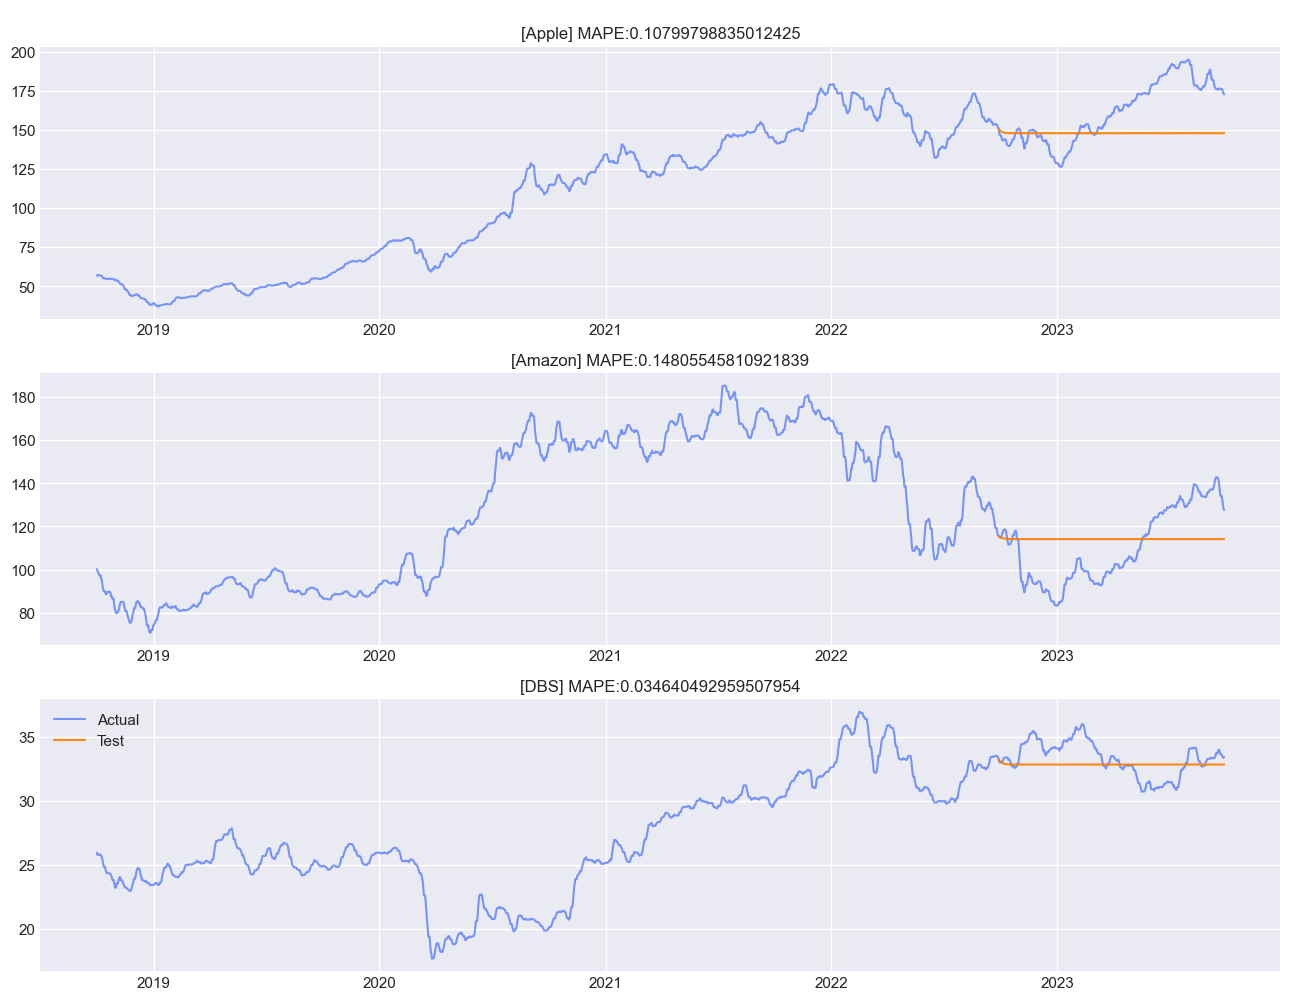

In [50]:
fig, axes = plt.subplots(3,1, figsize=(16, 12))

for idx, column in enumerate(df.columns):
    mod = HWES(train_data[df.columns[idx]], seasonal_periods=7, trend='add', seasonal='add', damped_trend=True, freq='D')
    res = mod.fit()

    pred = res.forecast(365)

    axes[idx].set_title("\n[{}] MAPE:{}".format(df.columns[idx], mean_absolute_percentage_error(test_data[df.columns[idx]],pred)))
    axes[idx].plot(df[df.columns[idx]], label = 'Actual', alpha=0.5)
    axes[idx].plot(pred, label='Test', alpha=0.9)
plt.legend()
plt.show()

<hr>

### Final Model
Although our model may have performed relatively well in terms of the metrics used for evaluation, they still failed to capture the complex and changing patterns in the stock data. Hence, we will choose our 3 final model for each column based on the best MAPE.

After trying all 3 models, we found the the best performing models are:
<ul>
<li>SARIMA - Apple & DBS</li>
<li>ARIMA - Amazon</li>
</ul>


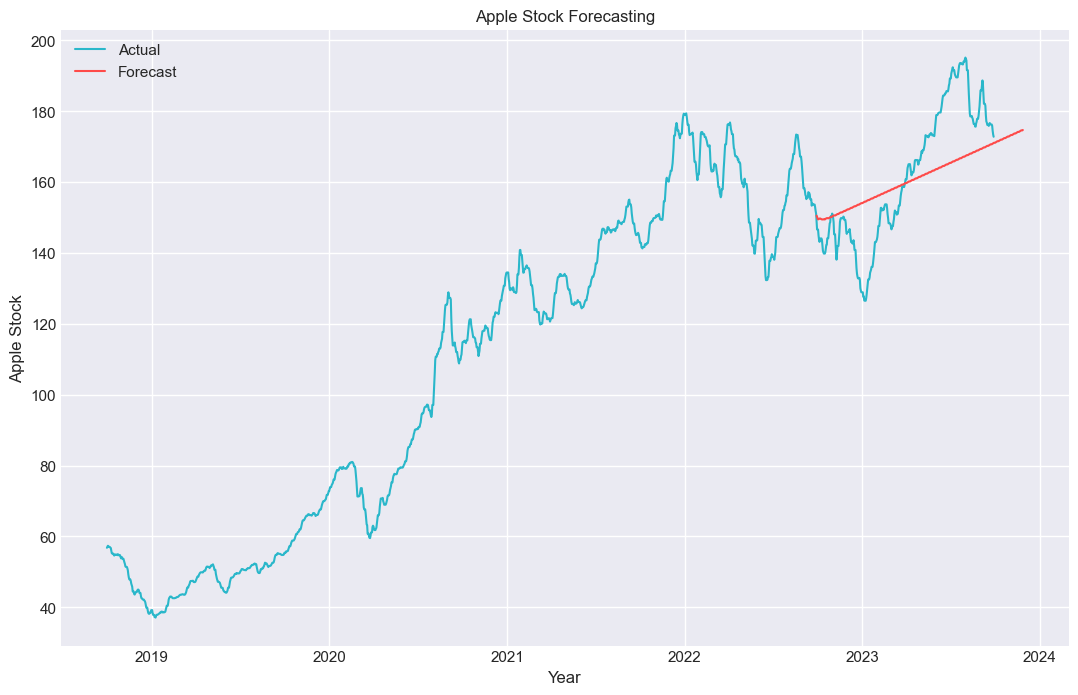

In [30]:
fig, axes = plt.figure(figsize=(13,8)), plt.gca()

apple_mod = SARIMAX(train_data['Apple'], order = (1,1,3), seasonal_order = (2,1,2,7))
res = apple_mod.fit()
pred = res.forecast(425)

axes.plot(df["Apple"], label = 'Actual', color=colors[1])
axes.plot(pred, label='Forecast',  color=colors[0])

axes.set_title("Apple Stock Forecasting")
plt.xlabel("Year")
plt.ylabel("Apple Stock")
plt.legend()
plt.show()

 The general increasing trend observed in the graph indicates that the predicted stock prices are projected to increase over the analyzed period. This suggests that the SARIMA model has successfully captured the long-term growth pattern shown in Apple's stock prices. However it fails to capture the fluctuation in the stock price.

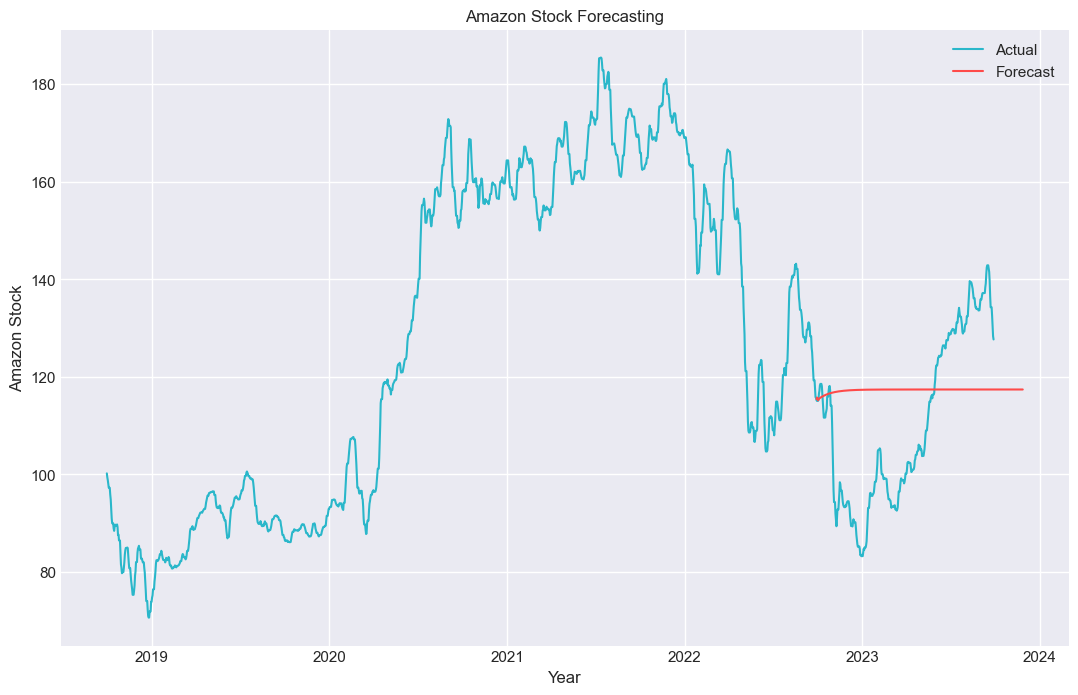

In [29]:
fig, axes = plt.figure(figsize=(13,8)), plt.gca()

amazon_mod = ARIMA(train_data['Amazon'], order=(2,1,9))
res = amazon_mod.fit()

pred = res.forecast(425)

actual_original_scale = df["Amazon"]
forecast_original_scale = pred

axes.plot(actual_original_scale, label='Actual', color=colors[1])
axes.plot(forecast_original_scale, label='Forecast', color=colors[0])

axes.set_title("Amazon Stock Forecasting")
plt.xlabel("Year")
plt.ylabel("Amazon Stock")

plt.legend()
plt.show()

While our ARIMA may not capture a clear trend of either increase or decrease in Amazon's stock prices due to their irregular nature, it still outperforms other models tested.

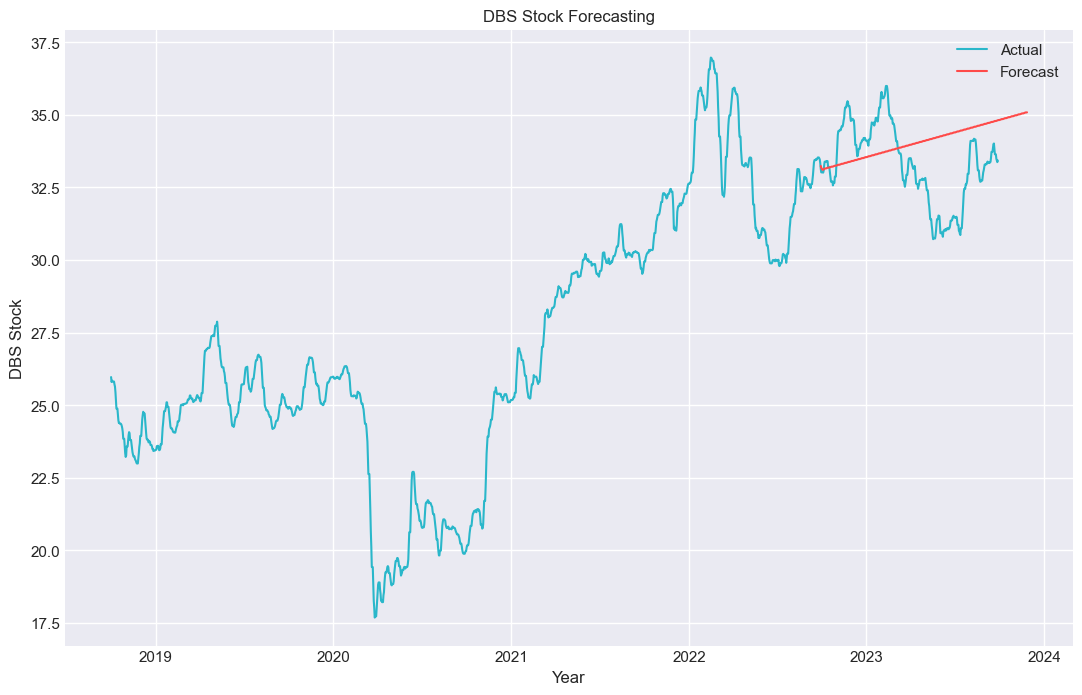

In [28]:
fig, axes = plt.figure(figsize=(13,8)), plt.gca()

DBS_mod = SARIMAX(train_data['DBS'], order = (2,1,1), seasonal_order = (1,1,1,7))
res = DBS_mod.fit()
pred = res.forecast(425)

axes.plot(df["DBS"], label = 'Actual', color=colors[1])
axes.plot(pred, label='Forecast', color=colors[0])

axes.set_title("DBS Stock Forecasting")
plt.xlabel("Year")
plt.ylabel("DBS Stock")
plt.legend()
plt.show()


The model used for DBS stock prices can predict the overall direction in which the stock prices are heading. However, it struggles to pick up on the finer details and patterns within the data. While it can give a general idea of whether the prices are going up or down, it doesn't capture the smaller ups and downs that happen over time.

<hr>

## Final Conclusion

<hr>

We have tried our best to succesfully create a model to predict the stock price for the next 60 days for each Company. However, the stock market, is unpredictable due to many factors like politics, global economy, and company performance. These factors cause stock prices to constantly change in unexpected ways. Hence, the difficulty in predicting stock prices of companies, maybe with more data we can train our model to better predict the trend of the stock market